In [587]:
import sys
sys.path.append("..")

from diffusion.heston_process import simulate_heston
from pricing.option_heston import option_heston
from pricing.option_bsm import option_european_bsm
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc("savefig", dpi=200)
%config InlineBackend.figure_format = 'svg'



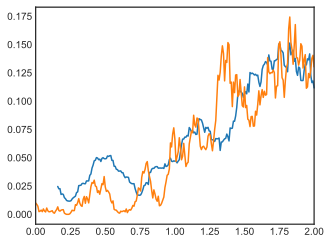

In [588]:
# Setting evaluation date
today = ql.Date(7,4,2015)

no_of_timestep = 252
N=1000
maturity = 2

df_spot, df_vol = simulate_heston(today=ql.Date(1, 7, 2020), timestep=no_of_timestep, length=maturity, N=N, 
                                  spot=100, rate=0.0,
                                  v0=0.01, kappa=1.0, theta=0.04, rho=-0.3, sigma=0.4)

((np.log(df_spot.xs(1).shift(1)) - np.log(df_spot.xs(1))).rolling(20).std() * np.sqrt(12)).plot()
df_vol.xs(1).plot()

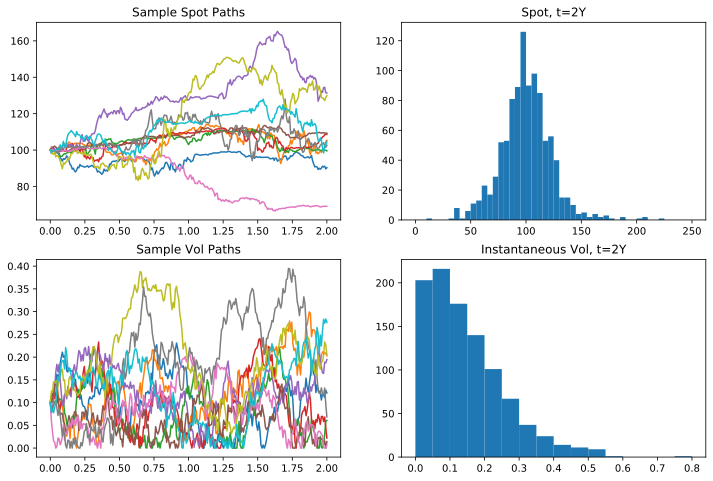

In [3]:

# Plot the first ten paths for spot and vol, and the distribution of the final path step across all paths
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df_spot.iloc[0:10].transpose())
plt.title("Sample Spot Paths")

plt.subplot(2, 2, 2)
plt.hist(df_spot[2.0], bins=np.linspace(0, 250, 51))
plt.title("Spot, t=2Y")

plt.subplot(2, 2, 3)
plt.plot(np.sqrt(df_vol.iloc[0:10]).transpose())
plt.title("Sample Vol Paths")

plt.subplot(2, 2, 4)
plt.hist(np.sqrt(df_vol[2.0]), bins=np.linspace(0, 0.8, 17))
plt.title("Instantaneous Vol, t=2Y")

# plt.savefig('figures/heston.png')
plt.show()

In [4]:
def customaxis(ax, c_left='k', c_bottom='k', c_right='none', c_top='none',
               lw=3, size=20, pad=8):

    for c_spine, spine in zip([c_left, c_bottom, c_right, c_top],
                              ['left', 'bottom', 'right', 'top']):
        if c_spine != 'none':
            ax.spines[spine].set_color(c_spine)
            ax.spines[spine].set_linewidth(lw)
        else:
            ax.spines[spine].set_color('none')
    if (c_bottom == 'none') & (c_top == 'none'): # no bottom and no top
        ax.xaxis.set_ticks_position('none')
    elif (c_bottom != 'none') & (c_top != 'none'): # bottom and top
        ax.tick_params(axis='x', direction='out', width=lw, length=7,
                      color=c_bottom, labelsize=size, pad=pad)
    elif (c_bottom != 'none') & (c_top == 'none'): # bottom but not top
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='x', direction='out', width=lw, length=7,
                       color=c_bottom, labelsize=size, pad=pad)
    elif (c_bottom == 'none') & (c_top != 'none'): # no bottom but top
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', direction='out', width=lw, length=7,
                       color=c_top, labelsize=size, pad=pad)
    if (c_left == 'none') & (c_right == 'none'): # no left and no right
        ax.yaxis.set_ticks_position('none')
    elif (c_left != 'none') & (c_right != 'none'): # left and right
        ax.tick_params(axis='y', direction='out', width=lw, length=7,
                       color=c_left, labelsize=size, pad=pad)
    elif (c_left != 'none') & (c_right == 'none'): # left but not right
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(axis='y', direction='out', width=lw, length=7,
                       color=c_left, labelsize=size, pad=pad)
    elif (c_left == 'none') & (c_right != 'none'): # no left but right
        ax.yaxis.set_ticks_position('right')
        ax.tick_params(axis='y', direction='out', width=lw, length=7,
                       color=c_right, labelsize=size, pad=pad)
        
def adjust_spines(ax,spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward',10)) # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none') # don't draw spine

FileNotFoundError: [Errno 2] No such file or directory: 'figures/heston.png'

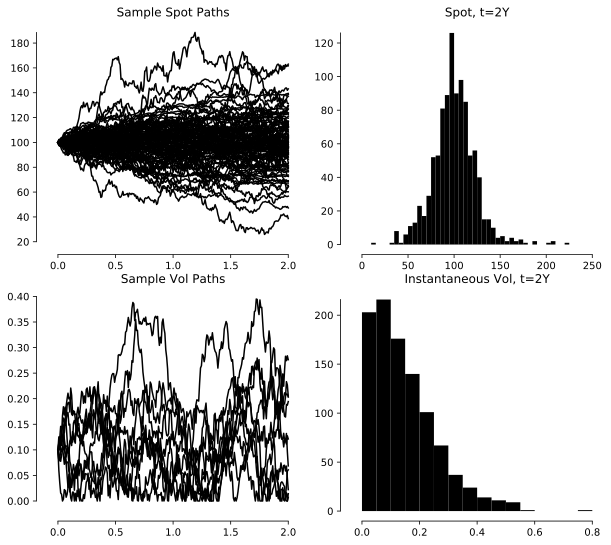

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fig,((ax1,ax2), (ax3, ax4)) = plt.subplots(figsize=(10,9), ncols=2, nrows=2)

ax1.plot(df_spot.iloc[0:100].transpose(), 'k')

ax1.set_title('Sample Spot Paths')

ax2.hist(df_spot[2.0], bins=np.linspace(0, 250, 51), color='k')
ax2.set_title('Spot, t=2Y')

ax3.plot(np.sqrt(df_vol.iloc[0:10]).transpose(), color='k')
ax3.set_title('Sample Vol Paths')

ax4.hist(np.sqrt(df_vol[2.0]), bins=np.linspace(0, 0.8, 17), color='k')
ax4.set_title('Instantaneous Vol, t=2Y')

# customaxis(ax2) # remove top and right spines, ticks out
adjust_spines(ax1, ['left', 'bottom']) # non touching spines
adjust_spines(ax2, ['left', 'bottom'])
adjust_spines(ax3, ['left', 'bottom'])
adjust_spines(ax4, ['left', 'bottom'])

plt.savefig('figures/heston.png')
plt.show()

## Simulate heston

In [589]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from math import exp, log, sqrt, pi
import pandas as pd
import time
start_time = time.time()

# simulate the asset paths under Heston model 
def EulerMilsteinSim(scheme, negvar, numPaths, rho, S_0, V_0, T, kappa, theta, sigma, r, q, dt ):
    num_time = int(T/dt) 
    S = np.zeros((num_time+1, numPaths)) 
    S[0,:] = S_0
    V = np.zeros((num_time+1, numPaths))
    V[0,:] = V_0
    Vcount0 = 0
    for i in range(numPaths):
        for t_step in range(1, num_time+1):
# the 2 stochastic drivers for variance V and asset price S and correlated             
            Zv = np.random.randn(1)
            Zs = rho*Zv + sqrt(1-rho**2)*np.random.randn(1)
# users can choose either Euler or Milstein scheme
            if scheme == 'Euler':
                V[t_step,i] =  V[t_step-1,i] + kappa*(theta-V[t_step-1,i])*dt+ sigma* sqrt(V[t_step-1,i]) * sqrt(dt)*Zv 
            elif scheme == 'Milstein':
                V[t_step,i] = V[t_step-1,i] + kappa*(theta-V[t_step-1,i])*dt + sigma* sqrt(V[t_step-1,i]) * sqrt(dt)*Zv \
                + 1/4 *sigma**2*dt*(Zv**2 -1)

            if V[t_step,i] <= 0:
                Vcount0 = Vcount0+1
                if negvar == 'Reflect':
                    V[t_step,i] = abs(V[t_step,i])
                elif negvar == 'Trunca':
                    V[t_step,i] = max( V[t_step,i] , 0 )
                    
            ################         simluations for asset price S              ########
            S[t_step,i] = S[t_step-1,i] * np.exp( (r-q-V[t_step-1,i]/2)*dt + sqrt(V[t_step-1,i])*sqrt(dt)* Zs)
    return S, V, Vcount0

### Calibrate heston

In [590]:
def estimate_heston(vols, spots, dt):
    n = len(vols)
    dt = dt
    P_numerator = ((vols.shift(1) * vols)**(1/2)).sum() / n  - 1/(n**2) * ((vols / vols.shift(1))**(1/2)).sum() * vols.shift(1).sum()
    P_denumerator = dt / 2 - dt / 2 * (1/n**2) * (1/vols.shift(1)).sum() * vols.shift(1).sum()
    P = P_numerator / P_denumerator

    kappa_est = 2/dt * (1 + P*dt/2 * 1/n * (1/vols.shift(1)).sum() - 1/n * ((vols / vols.shift(1))**(1/2)).sum())
    sigma_est = (4/dt/n * ((vols**(1/2) - vols.shift(1)**(1/2) - dt /(2*vols.shift(1)**(1/2)) * (P - kappa_est*vols.shift()))**2).sum())**(1/2)
    theta_est = (P + 1/4*sigma_est**2) / kappa_est
    
    
    sigma_gbm_est = np.log(spots).diff().std() / np.sqrt(dt)
    r = ((np.log(spots).diff()).mean(axis=0) * (1 / dt) + (sigma_gbm_est ** 2) / 2)
    
    dW1 = (np.log(spots) - np.log(spots.shift(1)) - (r - 1/2*vols.shift(1)) * dt) / vols.shift(1)**(1/2)
    dW2 = (vols - vols.shift(1) - kappa_est *(theta_est - vols.shift(1)) * dt) / (sigma_est * vols.shift(1)**(1/2))
    ro = 1/n/dt * (dW1 * dW2).sum()
    
    return r, kappa_est, sigma_est, theta_est, ro

### 1. Calibrating against the log return- variances

In [638]:

##############################################   Parameters Values     ##############################################
numPaths = 20
rho = 0.8         # correlation of the bivariables
S_0 = 1             # initila asset price
V_0 = 0.1      # initial variance
kappa = 2           # mean-reversion rate 
theta = (0.3)**2    # long-run variance
sigma = 0.1         # volatility of volatility
r = 0.1            # risk-free interest rate
q = 0.0             # dividend
dt = 1/252         # size of time-step 
Tmax = 10            # longest maturity 

scheme='Milstein'
negvar='Trunca'
S, V, Vcount0 = EulerMilsteinSim(scheme, negvar, numPaths, rho, S_0 , V_0, Tmax, kappa, theta, sigma, r, q, dt)
df_spot = pd.DataFrame(S).T
df_vol=pd.DataFrame(V).T

df_log_vols = (np.log(df_spot.xs(1)) - np.log(df_spot.xs(1).shift(1)) ).rolling(20).std() * np.sqrt(12)
# df_log_vols = (((df_spot.xs(1) - df_spot.xs(1).shift(1)) / df_spot.xs(1).shift(1)  ).rolling(252).std() * np.sqrt(1))
# df_log_vols.plot(label='std(logreturn) vols')


vols_original = df_vol.xs(1).dropna()
spots = df_spot.xs(1)
vols = vols_original
mu_est, kappa_est, sigma_est, theta_est, rho_est = estimate_heston(vols, spots, dt)
print('Estimated mu: %.2f, kappa: %.2f, sigma: %.2f, theta %.2f, ro %.2f ' % (mu_est, kappa_est, sigma_est, theta_est, rho_est))
print('Original mu: %.2f, kappa: %.2f, sigma: %.2f, theta %.2f, ro %.2f  ' % (r, kappa, sigma, theta, rho))



Estimated mu: 0.12, kappa: -4.55, sigma: 0.10, theta 0.09, ro 0.76 
Original mu: 0.10, kappa: 2.00, sigma: 0.10, theta 0.09, ro 0.80  


## Calibrating with given volatilities

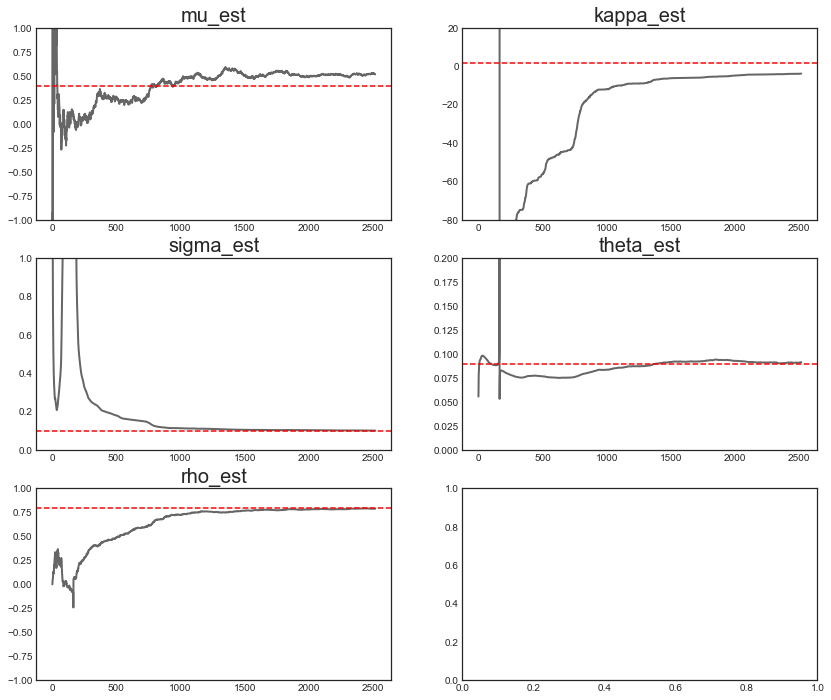

In [392]:
mu_list = []
kappa_list = []
sigma_list = []
theta_list = []
rho_list = []

for i in range(2, len(df_vol.T[el])):
    mu_est, kappa_est, sigma_est, theta_est, rho_est = estimate_heston(df_vol.T[el][0:i], df_spot.T[el][0:i], dt)
    mu_list.append(mu_est)
    kappa_list.append(kappa_est)
    sigma_list.append(sigma_est)
    theta_list.append(theta_est)
    rho_list.append(rho_est)
df_estimates_stability = pd.DataFrame(np.column_stack([mu_list, kappa_list, sigma_list, theta_list, rho_list]), 
                               columns=['mu_est', 'kappa_est', 'sigma_est', 'theta_est', 'rho_est'])

plt.style.use('seaborn-white')
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes[0, 0].plot(range(0, len(df_estimates_stability[[ 'mu_est']])), df_estimates_stability[[ 'mu_est']], "k", label="Estimated drift", lw=2, alpha=0.6)
axes[0, 0].axhline(y=r, color='r', linestyle='--', label='Original Drift')
axes[0, 0].set_title("mu_est", size=20)
axes[0, 0].set_ylim([-1, 1])
# axes[0].legend(fontsize=18)

axes[0, 1].plot(range(0, len(df_estimates_stability[[ 'kappa_est']])), df_estimates_stability[[ 'kappa_est']], "k", label="Estimated Volatility", lw=2, alpha=0.6)
axes[0, 1].axhline(y=kappa, color='r', linestyle='--', label='Original Volatility')
axes[0, 1].set_title("kappa_est", size=20)
axes[0, 1].set_ylim([-80, 20])

axes[1, 0].plot(range(0, len(df_estimates_stability[[ 'sigma_est']])), df_estimates_stability[[ 'sigma_est']], "k", label="Estimated Volatility", lw=2, alpha=0.6)
axes[1, 0].axhline(y=sigma, color='r', linestyle='--', label='Original Volatility')
axes[1, 0].set_title("sigma_est", size=20)
axes[1, 0].set_ylim([0, 1])

axes[1, 1].plot(range(0, len(df_estimates_stability[[ 'theta_est']])), df_estimates_stability[[ 'theta_est']], "k", label="Estimated Volatility", lw=2, alpha=0.6)
axes[1, 1].axhline(y=theta, color='r', linestyle='--', label='Original Volatility')
axes[1, 1].set_title("theta_est", size=20)
axes[1, 1].set_ylim([0, 0.2])

axes[2, 0].plot(range(0, len(df_estimates_stability[[ 'rho_est']])), df_estimates_stability[[ 'rho_est']], "k", label="Estimated Volatility", lw=2, alpha=0.6)
axes[2, 0].axhline(y=rho, color='r', linestyle='--', label='Original Volatility')
axes[2, 0].set_title("rho_est", size=20)
axes[2, 0].set_ylim([-1, 1])

plt.savefig('C:/Users/eyyup/Desktop/DTU/master thesis/plots/heston_stability_calibration.png')

## Tracking the volatilities- CEKF

C:\python\WPy64-3741\python-3.7.4.amd64\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 

0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 

0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 nan 0.0
0.11699246899590651 nan 0.0 

KeyboardInterrupt: 

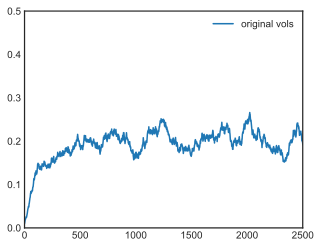

In [694]:

##############################################   Parameters Values     ##############################################
numPaths = 2
rho = 0.8         # correlation of the bivariables
S_0 = 100             # initila asset price
V_0 = 0.2      # initial variance
kappa = 2           # mean-reversion rate 
theta = 0.2    # long-run variance
sigma = 0.1       # volatility of volatility
r = 0.1            # risk-free interest rate
q = 0.0             # dividend
dt = 1/252         # size of time-step 
Tmax = 10            # longest maturity 

scheme='Milstein'
negvar='Trunca'
S, V, Vcount0 = EulerMilsteinSim(scheme, negvar, numPaths, rho, S_0 , V_0, Tmax, kappa, theta, sigma, r, q, dt)
df_spot = pd.DataFrame(S).T.xs(1)
df_vol=pd.DataFrame(V).T.xs(1)


df_vol.plot(label='original vols')
plt.legend()
plt.axis([ 0, 2500, 0, 0.5])
#### ESTIMATION OF VOLATILITIES
# Initialization
Vk, Pk = 0.1, 0.1
# kappa, theta, sigma, rho = 1, 0.03, 0.1, 0.1
Q=np.array([[1, 0],
            [0, 1]])
K_array=np.zeros(len(spots))  
Vk_array=np.zeros(len(spots))  
P_array=np.zeros(len(spots))  


mu_est, kappa_est, sigma_est, theta_est, rho_est = 0.1, 0.2, 0.2, 0.2, 0.2
for k in range(len(spots)-1):
    # Linearization matrices of the state function
    F = 1 - kappa_est*dt
    L = np.array([0, sigma_est*np.sqrt(max(Vk * dt, 0))])
    
    # Update the state prediction estimation and the prediction estimation-error covariance
    Vk1 = Vk + kappa_est*theta_est*dt - kappa_est*Vk*dt
    
    dQ = Pk*np.abs(1-kappa_est*dt)**2 + dt**2 * np.abs(kappa_est*theta_est)**2 + np.abs(sigma_est)**2 * dt * Vk * Q[1, 1] - F*Pk*F + L@Q@L.T
#     dQ=0
    Pk1 = F*Pk*F + L@Q@L.T + dQ

    # Linearization matrices of the measurement function
    H = -1/2*dt
    M = np.array([np.sqrt(max((1 - rho_est**2) * Vk * dt, 0)), rho_est*np.sqrt(max(Vk*dt, 0))])
    
    # Update the state estimate and error covariance
    K = (Pk1*H + L @ Q @ M.T) * (H*Pk*H + M@Q@M.T + H*(L@Q@M.T) + (M@Q@L)*H)**(-1)
    
    zk = np.log(spots[k+1]) - np.log(spots[k])
    Vk1 = Vk1 + K * (zk - (r-1/2*Vk1)*dt)
    
    dR = Pk1 * (1 + K*dt/2)**2 + 2*K**2 * dt*Vk*((1-rho_est**2)*Q[0,0] + rho_est**2 * Q[1,1]) - Pk1 + K*(H*Pk1 + M@L.T) 
#     dR=0
    Pk1 = Pk1 - K * (H*Pk1 + M@L.T) + dR
    
    Vk, Pk = np.abs(Vk1), Pk1
    
    K_array[k] = K
    Vk_array[k] = Vk
    P_array[k] = Pk
    
    mu_est, kappa_est, sigma_est, theta_est, rho_est = estimate_heston(pd.Series(Vk_array), spots, dt)
    print(mu_est, kappa_est, sigma_est, theta_est, rho_est)
# n = Vk_array.shape[0]
# beta1 = (n**(-2) * np.sum(Vk_array[1:])* np.sum(1/Vk_array[:-1]) - 1/n * np.sum(Vk_array[1:] * Vk_array[:-1])) / (n**(-2)*np.sum(Vk_array[:-1])*np.sum(1/Vk_array[:-1]) - 1)
# beta2 = (n**(-1) * np.sum(Vk_array[1:] / Vk_array[:-1]) - beta1) / (1-beta1)*n**(-1)*np.sum(1/Vk_array[:-1])
# beta3 = n**(-1)*np.sum(Vk_array[1:] - Vk_array[:-1]*beta1 -beta2*(1-beta1)**2)/Vk_array[:-1]
# print(-1/dt*log(beta1))
# print(beta2)
    
plt.plot(Vk_array, label='CEKF')
plt.legend()

plt.axis([ 0, 2500, 0, 1])
plt.legend()

mu_est, kappa_est, sigma_est, theta_est, rho_est = estimate_heston(pd.Series(Vk_array), spots, dt)

print('Estimated mu: %.2f, kappa: %.2f, sigma: %.2f, theta %.2f, ro %.2f ' % (mu_est, kappa_est, sigma_est, theta_est, rho_est))
print('Original mu: %.2f, kappa: %.2f, sigma: %.2f, theta %.2f, ro %.2f  ' % (r, kappa, sigma, theta, rho))

plt.show()
df_spot.plot()

In [685]:
Vk_array

array([0.11511941, 0.12977792, 0.13147181, ..., 0.18548475, 0.18566206,
       0.        ])

## EKF

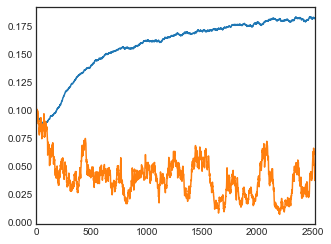

In [514]:
#### ESTIMATION OF VOLATILITIES
# Initialization
Vk, Pk = 0.1, 0.9
# kappa, theta, sigma, rho = 4, 0.03, 0.1, 0.1
S = 0.9


vk_list = []
for k in range(len(spots)-1):
    # Linearization matrices of the state function
    F = 1 - kappa*dt
    H = -1/2*dt
    
    # prediction
    Vk = Vk + kappa*theta*dt - kappa*Vk*dt
    Pk = F * Pk * F + 0.1
    
    #update
    S = H*Pk*H + 1
    K = Pk*H/S
    
    Vk = Vk + K * (np.log(spots[k+1]) - np.log(spots[k]) - 1/2*Vk)
    Pk = (1 - K*H)*Pk
    
    vk_list.append(Vk)


plt.plot(vk_list)
df_vol.plot(label='original vols')

In [ ]:

def likelihoodAW(params, x, r, q, dt, method):
    
